# CTAO Simulation of NGC 1068 with Ajello+ 2023 Starburst Model

In [3]:
# Imports
import numpy as np

import glob, os, itertools

from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
from astropy.time import Time
from astropy.table import Table
from astropy.io import ascii

import matplotlib.pyplot as plt 

from regions import CircleSkyRegion

from gammapy.data import Observation, observatory_locations, FixedPointingInfo, DataStore
from gammapy.irf import load_irf_dict_from_file
from gammapy.maps import MapAxis, RegionGeom, WcsGeom, Map
from gammapy.datasets import SpectrumDataset, Datasets, FluxPointsDataset, MapDataset, MapDatasetEventSampler
from gammapy.makers import SpectrumDatasetMaker, SafeMaskMaker, ReflectedRegionsBackgroundMaker, MapDatasetMaker
from gammapy.modeling import Fit
from gammapy.modeling.models import (SkyModel, EBLAbsorptionNormSpectralModel, PointSpatialModel, ExpCutoffPowerLawSpectralModel, FoVBackgroundModel, Models, 
                                     PowerLawSpectralModel, LogParabolaSpectralModel, SmoothBrokenPowerLawSpectralModel, TemplateSpectralModel, BrokenPowerLawSpectralModel)
from gammapy.catalog import CATALOG_REGISTRY
from gammapy.estimators import FluxPointsEstimator
from gammapy.visualization import plot_spectrum_datasets_off_regions

To simulate the spectrum of our source we first need to create the source with an input model. Afterwards we create an observation from the Cherenkov Telescope Array Observatory (CTAO). The format of this data needs to be 3 dimensional. After creating the observation we simulate the events and input them into the observation. We then do an standard spectral analysis with the simulated data and finally perform a fitting.

## Simulations of multiple observations

We can simulate the same sources for a number of observations, where the starting time and the livetime are changing. We are going to simulate the source for N observations, with a random cadence between them.

### Creating our Source

<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='e2dnde [$\\mathrm{erg\\,s^{-1}\\,cm^{-2}}$]'>

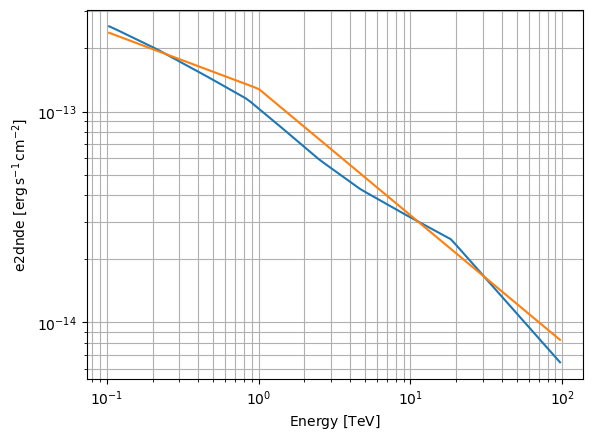

In [17]:
target_position = SkyCoord(40.669 * u.deg, -0.013 * u.deg, frame="icrs", unit="deg")

# Template spectral model. Defined by values from Ajello+ 2023
data = ascii.read("/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Ajello_starburst/Ajello_starburst.csv")

# Getting the model in the correct units
energy = data['x'] *u.GeV
flux = data['y'] *u.GeV / (u.cm **2.0 * u.s)

# Sort data by energy
sorted_indices = np.argsort(energy)
energy = energy[sorted_indices]
flux  = flux[sorted_indices]

energy_MeV = energy.to(u.MeV)

# Sort data by energy
sorted_indices = np.argsort(energy)
energy = energy[sorted_indices]
flux= flux[sorted_indices]

flux = flux.to(u.MeV / (u.cm ** 2.0 * u.s))
flux_MeV = flux / energy_MeV**2  # divide by energy to get dN/dE

# Sort data by energy
sorted_indices = np.argsort(energy)
energy = energy[sorted_indices]
flux_MeV = flux_MeV[sorted_indices]

energy_bounds = [0.1, 100] * u.TeV
template_spec_model = TemplateSpectralModel(energy=energy_MeV, values=flux_MeV)
template_spec_model.plot(energy_bounds, sed_type="e2dnde")
plt.grid(which="both")

# Getting the background
bkg_model = FoVBackgroundModel(dataset_name="my-dataset")

# Creating the satial model
spatial_model = PointSpatialModel.from_position(target_position)

spectral_model = BrokenPowerLawSpectralModel(
    index1 = 2.27,
    index2=2.6,
    amplitude="0.8e-13 TeV-1 cm-2 s-1",
    ebreak="1 TeV",
)

spectral_model.plot(energy_bounds, sed_type="e2dnde")

### Creating the Dataset

In [3]:
# Ereco and Etrue must to be different: Etrue must have a larger range in order to reconstruct in the correct way (knowledge of the whole photon energy extension)
energy_axis = MapAxis.from_energy_bounds(
    "0.1 TeV", "100 TeV", nbin=10, per_decade=True
    )

# for the Edisp
energy_axis_true = MapAxis.from_energy_bounds(
    "0.01 TeV", "200 TeV", nbin=20, per_decade=True, name="energy_true"
    )

migra_axis = MapAxis.from_bounds(
    0.5, 2, nbin=150, node_type="edges", name="migra" # If node_type = ‘edge’ then bounds correspond to the lower
                                                      # and upper bound of the first and last bin.
    )

pointing = FixedPointingInfo(
    fixed_icrs= SkyCoord(40.169 * u.deg, -0.013 * u.deg, frame="icrs", unit="deg"),
) # A bit offset from source position

# let's define the geometry of the simulation:
geom = WcsGeom.create(
    skydir=pointing.fixed_icrs,           
    width=(4, 4),         # gammapy uses a square not a circle 
    binsz=0.02,           # pixel size
    frame="icrs",
    axes=[energy_axis],    # in reco energy
)    

# MapDataset object with zer0-filled map
empty = MapDataset.create(
        geom,                               
        energy_axis_true=energy_axis_true,       # for the IRF maps
        migra_axis=migra_axis,                   # for the Edisp map
        name="my-dataset",                       # the name that will read the FoVBKG
            )

maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"]) # which maps to make (by default all)

### Running Simulation

In [4]:
# Parameters
total_hours = 28
obs_duration = 0.5  # 30 minutes in hours
n_obs = int(total_hours / obs_duration)

# Generate tstart_obs with increasing values (non-simultaneous), spread out in time
# We use an arbitrary starting point and step to ensure separation
tstart_obs = np.linspace(0.083, 5, n_obs) * u.d

# All observations are 30 minutes
livetime_obs = np.full(n_obs, obs_duration) * u.hr

# Generate angle_wobble cycling through [0, 90, 180, 270]
base_angles = [0, 90, 180, 270]
angle_wobble = [base_angles[i % 4] for i in range(n_obs)] * u.deg

# Combine into a table for visualization
obs_table = Table(
    [tstart_obs, livetime_obs, angle_wobble],
    names=["tstart_obs", "livetime_obs", "angle_wobble"]
)

# Print the first few observations to verify
print(obs_table[:10])

# Verification checks
print("\nTotal livetime (hr):", np.sum(livetime_obs))
print("Number of observations:", n_obs)


    tstart_obs     livetime_obs angle_wobble
        d               h           deg     
------------------ ------------ ------------
             0.083          0.5          0.0
            0.1724          0.5         90.0
            0.2618          0.5        180.0
            0.3512          0.5        270.0
            0.4406          0.5          0.0
0.5299999999999999          0.5         90.0
            0.6194          0.5        180.0
0.7087999999999999          0.5        270.0
0.7981999999999999          0.5          0.0
            0.8876          0.5         90.0

Total livetime (hr): 28.0 h
Number of observations: 56


In [5]:
# Get all files in the ./sims directory
files = glob.glob('./sims/*')

# Loop and delete each file
for f in files:
    if os.path.isfile(f):
        os.remove(f)
        print(f"Deleted file: {f}")

Deleted file: ./sims/events_obs43.fits
Deleted file: ./sims/events_obs14.fits
Deleted file: ./sims/events_obs38.fits
Deleted file: ./sims/events_obs0.fits
Deleted file: ./sims/events_obs18.fits
Deleted file: ./sims/events_obs34.fits
Deleted file: ./sims/events_obs22.fits
Deleted file: ./sims/events_obs23.fits
Deleted file: ./sims/events_obs35.fits
Deleted file: ./sims/events_obs19.fits
Deleted file: ./sims/events_obs1.fits
Deleted file: ./sims/events_obs39.fits
Deleted file: ./sims/events_obs15.fits
Deleted file: ./sims/events_obs42.fits
Deleted file: ./sims/events_obs49.fits
Deleted file: ./sims/events_obs32.fits
Deleted file: ./sims/events_obs24.fits
Deleted file: ./sims/events_obs53.fits
Deleted file: ./sims/events_obs45.fits
Deleted file: ./sims/events_obs12.fits
Deleted file: ./sims/events_obs28.fits
Deleted file: ./sims/events_obs6.fits
Deleted file: ./sims/events_obs7.fits
Deleted file: ./sims/events_obs29.fits
Deleted file: ./sims/events_obs13.fits
Deleted file: ./sims/events_o

In [6]:
# The telescopes Instrument Response Function
irf_filename = "/Users/tharacaba/Desktop/Tesis_2/gammapy-datasets/1.3/cta-prod5-zenodo-fitsonly-v0/fits/CTA-Performance-prod5-v0.1-North-40deg.FITS/Prod5-North-40deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits"  
IRF = load_irf_dict_from_file(irf_filename)

# Parameters for observation
location = observatory_locations["cta_north"]
reference_time = Time("2026-05-28T00:00:00", format="isot", scale="utc")

# Model of our source
sky_model = SkyModel(
                    spectral_model=template_spec_model,
                    spatial_model=spatial_model,
                    name="NGC_1068",
                    )

model_obs = Models([sky_model, bkg_model])

dataset_original = model_obs.copy()        # We need it for spectrum plot

print(model_obs)


Models

Component 0: SkyModel

  Name                      : NGC_1068
  Datasets names            : None
  Spectral model type       : TemplateSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    lon_0                         :     40.669   +/-    0.00 deg         
    lat_0                         :     -0.013   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : my-dataset-bkg
  Datasets names            : ['my-dataset']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                  (frozen):      0.000                   
    reference             (frozen):      1.000       TeV         




In [7]:
# Simulating observations
for i, (tobs, liveobs, wobobs) in enumerate(zip(tstart_obs, livetime_obs, angle_wobble)):

    pointing_obs = target_position.directional_offset_by(wobobs, 0.5*u.deg)
    obs = Observation.create(
                            obs_id=i, 
                            pointing=pointing_obs, 
                            livetime=liveobs, 
                            irfs=IRF,
                            location=location,
                            reference_time = reference_time, 
                            tstart = tobs
                  )    

    dataset = maker.run(empty, obs) 
    dataset.models = model_obs

    sampler = MapDatasetEventSampler(random_state=0)
    events = sampler.run(dataset, obs)

    obs.events = events
    obs.write(f"./sims/events_obs{i}.fits", include_irfs=False, overwrite=True)


/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/gammapy/data/observations.py:294: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
The meta information will be empty here.
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/gammapy/data/observations.py:294: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
The meta information will be empty here.
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/gammapy/data/observations.py:294: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
The meta information will be empty here.
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/gammapy/data/observations.py:294: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
The meta information 

### Verifications

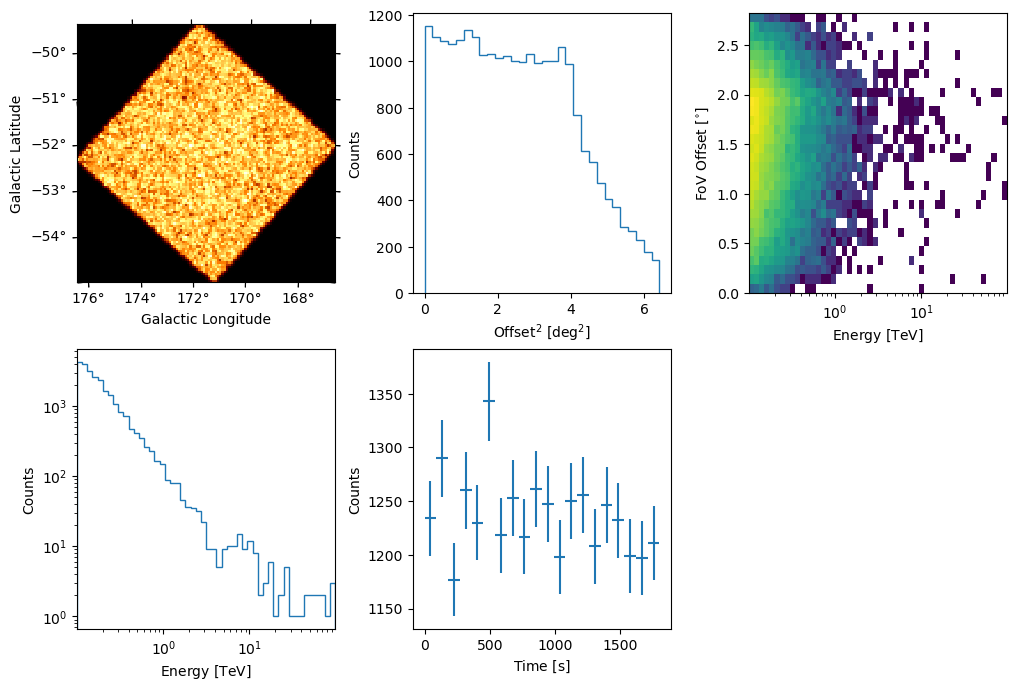

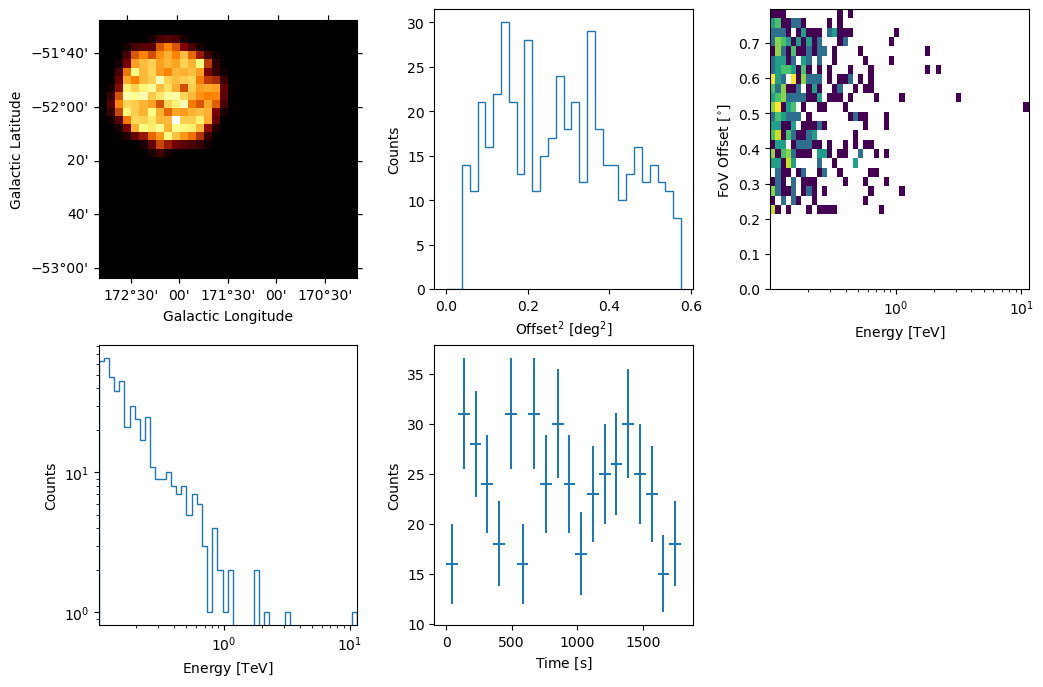

In [8]:
# let's have a look at the events
events.peek()

# Focusing on our source
src_pos = SkyCoord(ra="40.669 deg", dec="-0.013 deg", 
                   frame="icrs")

region_sky = CircleSkyRegion(center=src_pos, radius=0.3 * u.deg)
evt = events.select_region(region_sky)
evt.peek()

## Source Detection

We do a 1D spectral analysis.

### Load our Data

In [9]:
input_filenames = []
input_filenames.append(glob.glob(os.path.join("./sims/", '*.fits')))
input_filenames = tuple(itertools.chain.from_iterable(input_filenames))

datastore = DataStore.from_events_files(np.sort(input_filenames), 
                                        irfs_paths="/Users/tharacaba/Desktop/Tesis_2/gammapy-datasets/1.3/cta-prod5-zenodo-fitsonly-v0/fits/CTA-Performance-prod5-v0.1-North-40deg.FITS/Prod5-North-40deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits")

observations = datastore.get_observations(obs_id=list(datastore.obs_table['OBS_ID']))

### Spectral Analysis

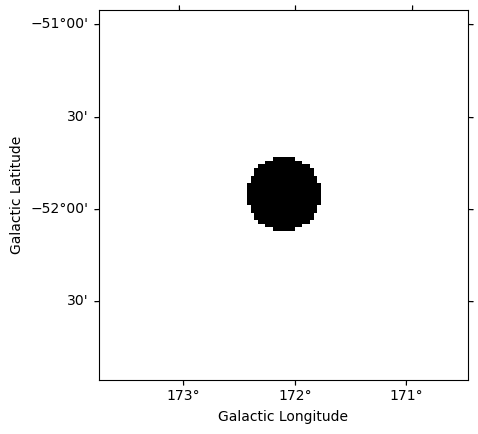

In [10]:
target_position = SkyCoord(40.669 * u.deg, -0.013 * u.deg, frame="icrs", unit="deg")

# We consider a square map of size 2.0 deg, spatially binned with bins of 0.02 deg;
# We define the ON region, assuming a circle of 0.2 deg of radius, for the source;
width = 2.0  #deg
binsz = 0.02 #deg
radius= 0.2  #deg

# Let's define an exclusion region, in order to better estimate the bkg:
SkyCoord(40.669 * u.deg, -0.013 * u.deg, frame="icrs", unit="deg")
on_region_radius = Angle(radius * u.deg)
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

npix = int(width/binsz)

exclusion_region = CircleSkyRegion(
    center=target_position,
    radius=radius * u.deg,
)

geom_excl = WcsGeom.create(
    npix=(npix, npix), binsz=binsz, skydir=target_position.galactic, proj="TAN", frame="galactic"
)

exclusion_mask = ~geom_excl.region_mask([exclusion_region])
exclusion_mask.plot()
plt.show()

In [11]:
# Create the reconstruced energy range:
e_min, e_max = 0.1 * u.TeV, 100 * u.TeV

energy_axis = MapAxis.from_energy_bounds(
    e_min, e_max, nbin=5, per_decade=True, unit="TeV", name="energy"
)

# Reduced IRFs are defined in true energy (i.e. not measured energy).
energy_axis_true = MapAxis.from_energy_bounds(
    0.01, 300, nbin=10, per_decade=True, unit="TeV", name="energy_true"
)

# Geometry defining the ON region and SpectrumDataset based on it
geom = RegionGeom.create(region=on_region, axes=[energy_axis])

dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

dataset_maker = SpectrumDatasetMaker(
    containment_correction=True, selection=["counts", "exposure", "edisp"]
)

# Tell the background maker to determine the reflected regions, excluding the source region:
maker_fov = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask)

# Let's impone a safe range for the analysis: we consider only events at a distance from the pointing direction < 1 deg.
offset_max = 2 * u.deg
safe_mask_masker = SafeMaskMaker(
    methods=["aeff-default","offset-max"], offset_max=offset_max
)

# Create a counts map for visualisation later...
counts = Map.create(skydir=target_position, width=3)

# Let's create the dataset for each observation and stack them all:
datasets = Datasets()

# Let's loop over observations
for observation in observations:
    # generate a dataset object
    dataset = dataset_maker.run(
        dataset_empty.copy(name=str(observation.obs_id)), observation
    )
    # Fill the dataset with the events of the observation
    counts.fill_events(observation.events)

    # Calculate the bkg
    dataset_on_off = maker_fov.run(dataset, observation)
    # Set a safe range for the analysis
    dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)

    datasets.append(dataset_on_off)

No default upper safe energy threshold defined for obs 0
No default lower safe energy threshold defined for obs 0
No default upper safe energy threshold defined for obs 1
No default lower safe energy threshold defined for obs 1
No default upper safe energy threshold defined for obs 10
No default lower safe energy threshold defined for obs 10
No default upper safe energy threshold defined for obs 11
No default lower safe energy threshold defined for obs 11
No default upper safe energy threshold defined for obs 12
No default lower safe energy threshold defined for obs 12
No default upper safe energy threshold defined for obs 13
No default lower safe energy threshold defined for obs 13
No default upper safe energy threshold defined for obs 14
No default lower safe energy threshold defined for obs 14
No default upper safe energy threshold defined for obs 15
No default lower safe energy threshold defined for obs 15
No default upper safe energy threshold defined for obs 16
No default lower s

/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/regions/shapes/circle.py:160: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Circle(xy=xy, radius=radius, **mpl_kwargs)


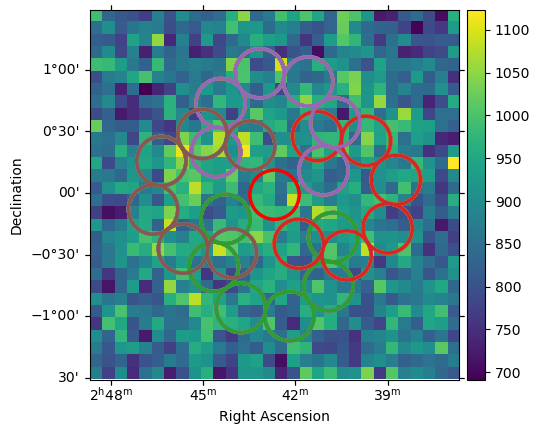

In [12]:
# Plot the counts map overimposing the ON-OFF regions
ax = counts.smooth(0.05 * u.deg).plot(stretch="linear", cmap="viridis", add_cbar=True)
geom.plot_region(ax=ax, kwargs_point={"color": "k", "marker": "*"}, color="r", linewidth=2.5)
plot_spectrum_datasets_off_regions(ax=ax, datasets=datasets, linewidth=2.5)
plt.show()

In [13]:
# We can also investigate the cumulative of all the runs:
info_table= datasets.info_table(cumulative=True)
info_table

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,227,18.33331298828125,1.1560263001996658,208.66668701171875,211.28571968297567,211.28571968297567,nan,28959.037109375,2667793664.0,1799.9999999999936,1799.9999999999936,0.12611111111111156,0.11592593722873305,0.010185173882378508,15,15,wstat,7.663082949672935,1252,15.0,89.99999237060547,0.1666666865348816
stacked,435,3.5,0.1557519134773112,431.5000305175781,432.0000134438883,432.0000134438883,nan,57918.07421875,5335587328.0,3599.999999999997,3599.999999999997,0.12083333333333345,0.11986111958821626,0.0009722222222222231,15,15,wstat,6.620675973452618,2589,30.0,180.0,0.1666666716337204
stacked,662,23.50006103515625,0.8550768616979875,638.4999389648438,641.8571631069086,641.8571631069086,nan,86877.109375,8003381248.0,5400.0,5400.0,0.12259259259259259,0.11824072943793403,0.004351863154658565,15,15,wstat,8.984499038644614,3831,45.0,270.0000305175781,0.1666666567325592
stacked,886,42.66668701171875,1.347400751953129,843.3333129882812,849.4285974186292,849.4285974186292,nan,115836.1484375,10671174656.0,7199.999999999984,7199.999999999984,0.12305555555555583,0.11712962680392822,0.005925928751627617,15,15,wstat,15.887214910228973,5060,60.0,360.0000305175781,0.1666666567325592
stacked,1113,61.0,1.7224148080566077,1052.0,1060.7142751825097,1060.7142751825097,nan,144795.1875,13338968064.0,8999.999999999987,8999.999999999987,0.12366666666666684,0.11688888888888906,0.006777777777777787,15,15,wstat,20.145420474409363,6312,75.0,450.0,0.1666666716337204
stacked,1321,46.166748046875,1.1889603209238173,1274.833251953125,1281.428507679577,1281.428507679577,nan,173754.21875,16006761472.0,10799.999999999985,10799.999999999985,0.12231481481481497,0.11804011592158581,0.0042746988932291724,15,15,wstat,21.115140345049205,7649,90.0,540.0000610351562,0.1666666567325592
stacked,1548,66.1668701171875,1.5780664944116682,1481.8331298828125,1491.2856458802587,1491.2856458802587,nan,202713.25,18674554880.0,12599.999999999975,12599.999999999975,0.12285714285714311,0.1176058039589536,0.0052513388981894945,15,15,wstat,23.902810826857888,8891,105.0,630.0001220703125,0.166666641831398
stacked,1772,85.3333740234375,1.905512417356185,1686.66650390625,1698.8571004891846,1698.8571004891846,nan,231672.28125,21342349312.0,14399.999999999978,14399.999999999978,0.12305555555555574,0.1171296183268231,0.005925928751627613,15,15,wstat,31.77443319240217,10120,120.0,720.0000610351562,0.1666666567325592


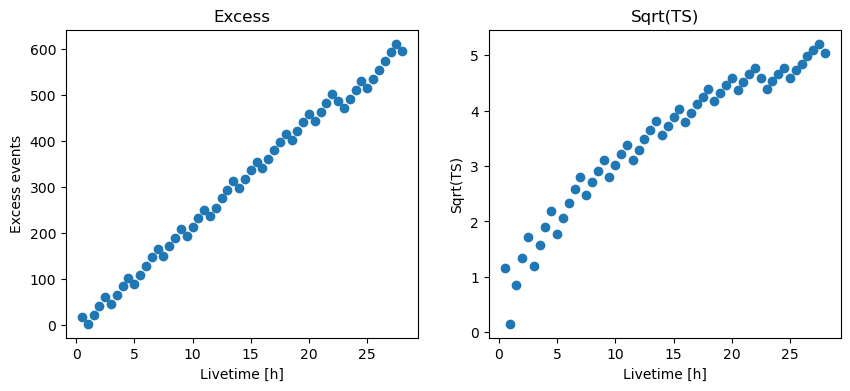

In [14]:
# We can plot the excess and the significance
fig, (ax_excess, ax_sqrt_ts) = plt.subplots(figsize=(10, 4), ncols=2, nrows=1)
ax_excess.plot(
    info_table["livetime"].to("h"),
    info_table["excess"],
    marker="o",
    ls="none",
)

ax_excess.set_title("Excess")
ax_excess.set_xlabel("Livetime [h]")
ax_excess.set_ylabel("Excess events")

ax_sqrt_ts.plot(
    info_table["livetime"].to("h"),
    info_table["sqrt_ts"],
    marker="o",
    ls="none",
)

ax_sqrt_ts.set_title("Sqrt(TS)")
ax_sqrt_ts.set_xlabel("Livetime [h]")
ax_sqrt_ts.set_ylabel("Sqrt(TS)")
plt.show()

## Extracting the Spectrum

We can perform a stacked analysis, i.e. all the datasets are stacked into a single dataset, where all the IRF properties are averaged. This is a reasonable choice as we do not expect so strong IRF property variations between the runs.

In [15]:
dataset_stacked = Datasets(datasets).stack_reduce()

### Fitting

In [16]:
# Let's fit the data with a powerlaw model

spectral_model = PowerLawSpectralModel(
    amplitude = 1.1717e-13 * u.Unit("cm-2 s-1 TeV-1"),
    index = 2.6115,
    reference = 1 * u.TeV,
)

# Let's fit the data with a Exponential Cutoff Power Law Spectral Model

# spectral_model = ExpCutoffPowerLawSpectralModel(
#    amplitude =  1.5570e-13 * u.Unit("cm-2 s-1 TeV-1"),
#    index = 2.60 ,
#    lambda_ = 1.56  * u.Unit("TeV-1"),
#    reference = 1 * u.TeV,
# )

# spectral_model.amplitude.min = 1e-15
# spectral_model.amplitude.max = 1e-11
# spectral_model.index.min = 1
# spectral_model.index.max = 3.0
# spectral_model.lambda_.min = 0.001
# spectral_model.lambda_.max = 10.0

# spectral_model.index.frozen = True
# spectral_model.amplitude.frozen = True
# spectral_model.lambda_.frozen = True

# Let's fit the data with a Logarithmic Parabla Spectral Model
# spectral_model = LogParabolaSpectralModel(
#     amplitude = 1e-13 * u.Unit("cm-2 s-1 TeV-1"),
#     alpha = 2.5,
#     beta = 0.3,
#     reference = 1 * u.TeV
# )

# spectral_model.alpha.min = 1.0
# spectral_model.alpha.max = 4.0
# spectral_model.beta.min = 0.0
# spectral_model.beta.max = 2.0

# spectral_model = SmoothBrokenPowerLawSpectralModel(
#     amplitude = 1.0866e-12 * u.Unit("cm-2 s-1 TeV-1"),
#     index1 = 1.0000,
#     index2 = 5.0 ,
#     ebreak = 7.7 * u.TeV,
#     reference = 1.0 * u.TeV,
#     smoothing = 0.3,
# )

# spectral_model.index1.min = 1.0
# spectral_model.index1.max = 3.0
# spectral_model.index2.min = 2.0
# spectral_model.index2.max = 6.0
# spectral_model.ebreak.min = 0.1 
# spectral_model.ebreak.max = 10 

#spectral_model.ebreak.frozen = True
#spectral_model.index2.frozen = True

# Fitting original spectrum

# set an energy range for the spectral fit
# dataset_stacked.mask_fit = dataset_stacked.counts.geom.energy_mask(
#     energy_min=0.1 * u.TeV, energy_max=30 * u.TeV
# )

# powerlaw = PowerLawSpectralModel(
#     amplitude=6.49e-7 * u.Unit("cm-2 s-1 TeV-1"),
#     index=2.35,
#     reference=1.0485e-3 * u.TeV
# )


# ebl = EBLAbsorptionNormSpectralModel.read_builtin("dominguez", redshift=0.00379)

# spectral_model = powerlaw * ebl

# # Make a SkyModel object
# model = SkyModel(spectral_model=spectral_model, name="NGC_1068")

# Template spectral model. Defined by values from Ajello+ 2023
# data = ascii.read("/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/Simulation/Ajello_Starburst/Ajello_starburst.csv")

# # Getting the model in the correct units
# energy = data['x'] *u.GeV
# flux = data['y'] *u.GeV / (u.cm **2.0 * u.s)

# energy_MeV = energy.to(u.MeV)

# flux = flux.to(u.MeV / (u.cm ** 2.0 * u.s))
# flux_MeV = flux / energy_MeV**2  # divide by energy to get dN/dE

# template_spec_model = TemplateSpectralModel(energy=energy_MeV, values=flux_MeV)

model = SkyModel(spectral_model = spectral_model, name="NGC_1068")


# Associate the model to the dataset
dataset_stacked.models = model

fit = Fit(store_trace=True)
minuit_opts = {"tol": 0.001, "strategy": 2}
fit.backend = "minuit"
fit.optimize_opts = minuit_opts

result_stacked = fit.run(dataset_stacked)

print(result_stacked)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 49
	total stat : 192.74

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [17]:
print(result_stacked.minuit)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 192.7                      │              Nfcn = 49               │
│ EDM = 2.31e-07 (Goal: 2e-06)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬───

In [18]:
dataset_stacked.models.parameters.to_table()

type,name,value,unit,error,min,max,frozen,link,prior
str1,str9,float64,str14,float64,float64,float64,bool,str1,str1
,index,2.7495e+00,,1.553e-01,nan,nan,False,,
,amplitude,9.3712e-14,TeV-1 s-1 cm-2,2.467e-14,nan,nan,False,,
,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,,


### Plotting the Spectrum

In [19]:
# I use the energy bins of the dataset. The `downsample` acts reducing the number of bins of a given integer.
energy_edges = energy_axis.downsample(1).edges 

# let's extract points for the `test_source` model. Errors will be at 1 sigma and upper limits at 3 sigma:
fpe = FluxPointsEstimator(
    energy_edges=energy_edges, source="NGC_1068", selection_optional="all", n_sigma=1, n_sigma_ul=3, n_jobs=7
)
flux_points = fpe.run(datasets=dataset_stacked)

flux_points.sqrt_ts_threshold_ul = 3

flux_points.to_table(sed_type="dnde", formatted=True)

e_ref,e_min,e_max,dnde,dnde_err,dnde_errp,dnde_errn,dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,stat_null,stat_scan,is_ul,counts,success,norm_scan
TeV,TeV,TeV,1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,float64,float64[11],bool,float64[1],bool,float64[11]
0.126,0.100,0.158,2.586e-11,1.022e-11,1.025e-11,1.019e-11,5.682e-11,6.513,2.552,6341.970110711903,217.13287,0.000,6.513,3.988 .. 115.683,True,6342.0,True,0.200 .. 5.000
0.200,0.158,0.251,2.665e-12,3.140e-12,3.154e-12,nan,1.221e-11,0.724,0.851,3150.0461418520676,51.38667,0.000,0.724,0.120 .. 123.381,True,3150.0,True,0.200 .. 5.000
0.316,0.251,0.398,-6.690e-13,9.763e-13,9.830e-13,9.830e-13,2.321e-12,0.465,-0.682,1427.9930503668618,-28.008564,0.000,0.465,1.280 .. 124.689,True,1428.0,True,0.200 .. 5.000
0.501,0.398,0.631,2.712e-12,3.511e-13,3.546e-13,3.477e-13,nan,70.182,8.377,783.9974386031141,228.66374,0.000,70.182,63.346 .. 1.389,False,784.0,True,0.200 .. 5.000
0.794,0.631,1.000,6.250e-13,1.255e-13,1.272e-13,1.238e-13,nan,28.622,5.350,405.99958813248645,106.33283,0.000,28.622,25.265 .. 3.984,False,406.0,True,0.200 .. 5.000
1.259,1.000,1.585,-7.449e-14,3.160e-14,3.239e-14,3.239e-14,2.772e-14,4.971,-2.230,97.99889718371804,-25.668037,0.000,4.971,6.298 .. 68.693,True,98.0,True,0.200 .. 5.000
1.995,1.585,2.512,-1.719e-14,1.208e-14,1.249e-14,1.249e-14,2.291e-14,1.848,-1.360,55.999188212688615,-11.667662,0.000,1.848,2.466 .. 34.984,True,56.0,True,0.200 .. 5.000
3.162,2.512,3.981,3.084e-14,7.434e-15,7.205e-15,7.205e-15,nan,23.165,4.813,83.98116884322387,39.646164,0.000,23.165,21.809 .. 2.452,False,84.0,True,0.200 .. 5.000


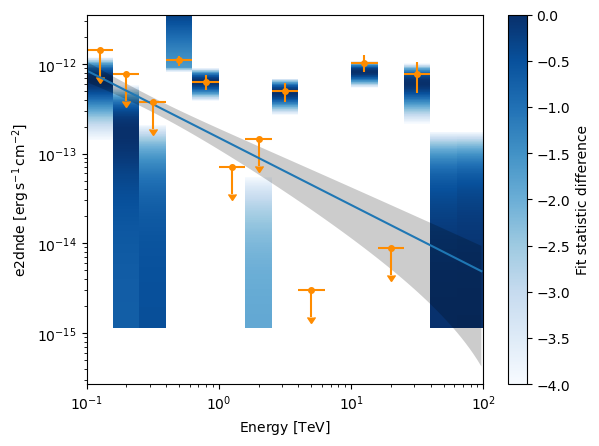

In [20]:
# Let's plot them, overlapping the significance
fig, ax = plt.subplots()
sed_type="e2dnde"
flux_points.plot(ax=ax, sed_type=sed_type, color="darkorange")
flux_points.plot_ts_profiles(ax=ax, sed_type=sed_type)
dataset_stacked.models[0].spectral_model.plot(ax=ax, energy_bounds=(e_min, e_max), sed_type=sed_type)
dataset_stacked.models[0].spectral_model.plot_error(ax=ax, energy_bounds=(e_min, e_max), sed_type=sed_type)
plt.show()

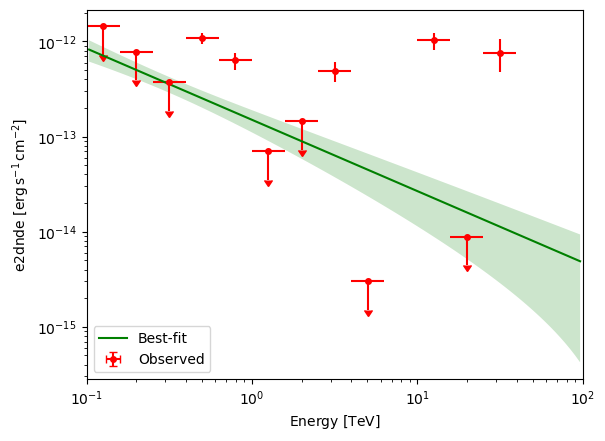

In [21]:
# Let's plot the best-fit model and the spectral points
fig, ax = plt.subplots()
sed_type="e2dnde"
flux_points.plot(ax=ax, sed_type=sed_type, color="red", label="Observed")
dataset_stacked.models[0].spectral_model.plot(ax=ax, energy_bounds=(e_min, e_max), sed_type=sed_type, color="green", label="Best-fit")
dataset_stacked.models[0].spectral_model.plot_error(ax=ax, energy_bounds=(e_min, e_max), sed_type=sed_type, facecolor="green")

plt.legend()

FluxPointsDataset
-----------------

  Name                            : oRktMPww 

  Number of total flux points     : 15 
  Number of fit bins              : 5 

  Fit statistic type              : chi2
  Fit statistic value (-2 log(L)) : 86.85

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : NGC_1068
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : 
    Temporal model type       : 
    Parameters:
      index                         :      2.749   +/-    0.16             
      amplitude                     :   9.37e-14   +/- 2.5e-14 1 / (TeV s cm2)
      reference             (frozen):      1.000       TeV         
  
  


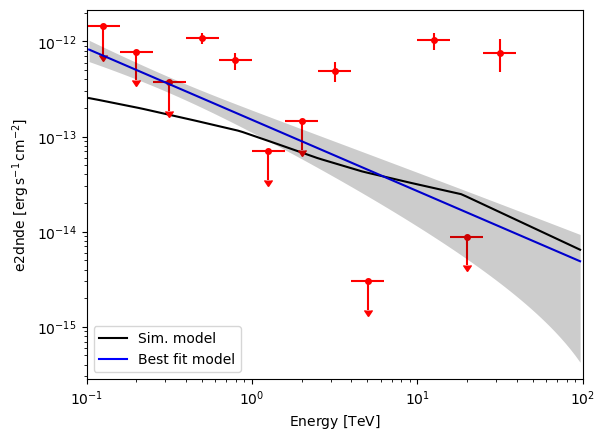

In [22]:
ax = dataset_original[0].spectral_model.plot(
    energy_bounds=[e_min, e_max] * u.TeV, 
    sed_type="e2dnde",
    label="Sim. model", 
    color='black'
    )

px = {"color": "red", "marker":"o"}
mx = {"color": "blue"}

# Fitting
# Quantify with the chi^2 statistic how well our parametric model of fit (that we made before) fits the spectral points
flux_points_dataset = FluxPointsDataset(data=flux_points, models=dataset_stacked.models[0])

flux_points_dataset.plot_spectrum(ax=ax, kwargs_fp=px, kwargs_model=mx)
#METHOD: Plot spectrum including flux points and model (defined in "flux_points_dataset")
#ax= axes to plot on; kwargs_fp= keywords for points; kwargs_model= keywords for model

ax.legend()
#ax.set_xlim(0.67,200)
#ax.set_ylim(2e-12,1e-10)

print(flux_points_dataset)

(<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='e2dnde [$\\mathrm{erg\\,s^{-1}\\,cm^{-2}}$]'>,
 <Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='Residuals\n (data - model) / model'>)

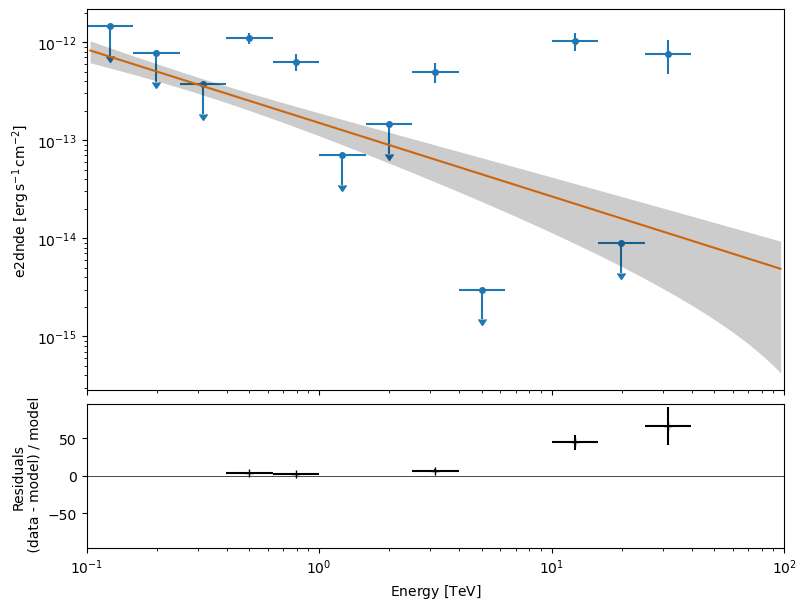

In [23]:
flux_points_dataset.plot_fit()